# Hybrid Recommendation System

In [1]:
# Import python libraries
import os
import numpy as np
from numpy import *
import pandas as pd
import re
import datetime as dt
# Import Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Import scikit learn libraries
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Import Cosine and Adjusted Cosine similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
# Import pickle to save and load the model
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Data Sourcing

In [2]:
#DATA_DIRECTORY = "/content/drive/MyDrive/UpGrad-LJMU/AmazonDataset/"
DATA_DIRECTORY = "data/"

Load the data from the input file

In [3]:
dataFileName = DATA_DIRECTORY + "Amazon_Fashion_5L.jsonl"
df = pd.read_json(dataFileName)

Print shape and first 5 rows

In [4]:
print(df.shape)
df.head()

(500000, 10)


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09 00:06:34.489,3,True
1,5,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True
2,2,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23 01:33:48.000,3,True
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31 20:57:27.095,2,True
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13 14:29:26.000,0,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             500000 non-null  int64         
 1   title              500000 non-null  object        
 2   text               500000 non-null  object        
 3   images             500000 non-null  object        
 4   asin               500000 non-null  object        
 5   parent_asin        500000 non-null  object        
 6   user_id            500000 non-null  object        
 7   timestamp          500000 non-null  datetime64[ns]
 8   helpful_vote       500000 non-null  int64         
 9   verified_purchase  500000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 38.6+ MB


### Exploratory Data Analysis

- Start with Handling Null values

In [6]:
def MissingData(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    null_count = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
    null_percentage = (
        df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]
    ).sort_values(ascending=False)
    null_data = pd.concat([null_count, null_percentage], axis=1, keys=["Count", "Percentage"])
    return null_data

In [7]:
MissingData(df)

,Count,Percentage


No Missing values

Check column images and drop as it will not be used for recommendation model building

In [8]:
df.drop(columns=["images"], axis=1, inplace=True)

- Checking for duplicate rows

In [9]:
# Checking for duplicate rows in the dataset
duplicate_count = df[df.duplicated() == True].shape[0]
print("Duplicate records count", duplicate_count)

Duplicate records count 1776


There are 25244 duplicate purchase data records, so these will be filtered as this will impact the further inference and model building

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
def print_user_items_count(data: pd.DataFrame):
    print("Dataset shape:", data.shape, "Users count:", data.user_id.nunique(), "Items count:", data.parent_asin.nunique())

print_user_items_count(df)

Dataset shape: (498224, 9) Users count: 342412 Items count: 289229


##### Analyze the verified purchase feature

In [12]:
df.verified_purchase.value_counts(normalize=True)

verified_purchase
True     0.911419
False    0.088581
Name: proportion, dtype: float64

Approximately 93.5% users items interactions are verified purchase and some 6.5% users have unverified purchase

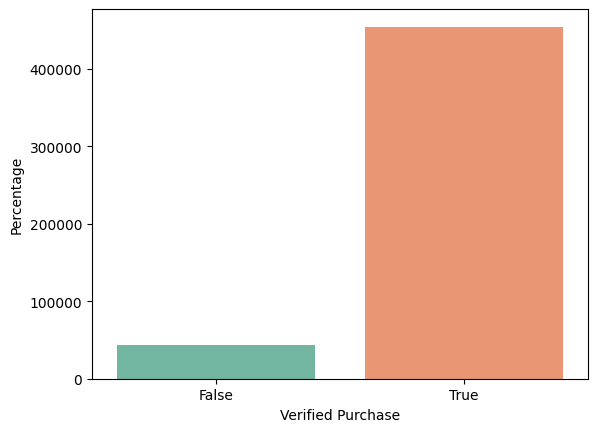

In [13]:
# Visualize using count plot
sns.countplot(x="verified_purchase", data=df, palette="Set2")
plt.xlabel("Verified Purchase")
plt.ylabel("Percentage")
plt.show()

We can see user verified purchase are way higher than unverified purchase

In [14]:
# Map the categorical verified_purchase to numerical 1 or 0 for Classification Model
df["verified_purchase"] = df["verified_purchase"].map({True: 1, False: 0})
# get the value count of verified_purchase column
df["verified_purchase"].value_counts(normalize=True)

verified_purchase
1    0.911419
0    0.088581
Name: proportion, dtype: float64

##### Analyze the Rating feature

In [15]:
df["rating"].value_counts(normalize=True)

rating
5    0.576658
4    0.153881
3    0.105416
1    0.096491
2    0.067554
Name: proportion, dtype: float64

Approximately 81% of reviews have rating of 3 and above. 57% of the reviews have rating of 5. 14% have rating of 4 and 10% have rating of 3

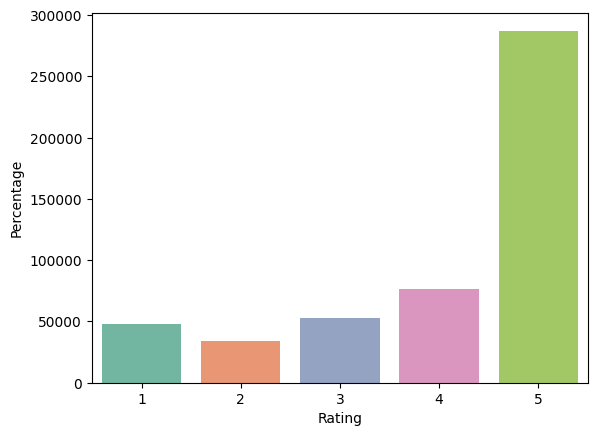

In [16]:
# visualize the rating.
sns.countplot(x="rating", data=df, palette="Set2")
plt.xlabel("Rating")
plt.ylabel("Percentage")
plt.show()

<AxesSubplot: xlabel='rating'>

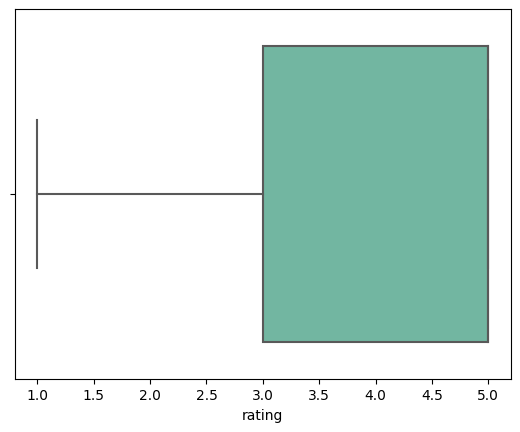

In [17]:
plt.rcdefaults()
sns.boxplot(x="rating", data=df, palette="Set2")

Most of the rating ranges from 3 to 5. So this will be used for data filtraion with minimum rating of 3.

##### Analyze the Rating and verified purchase for correlation analysis

Check the ratings for positive sentiment records

In [18]:
df[df["verified_purchase"] == 1]["rating"].value_counts(normalize=True)

rating
5    0.580236
4    0.148488
3    0.104583
1    0.098328
2    0.068365
Name: proportion, dtype: float64

Check the ratings and verified_purchase correlation

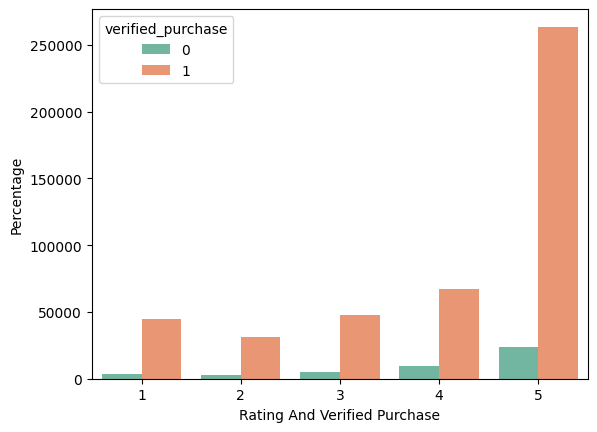

In [19]:
plt.rcdefaults()
sns.countplot(x="rating", data=df, hue='verified_purchase', palette='Set2')
plt.xlabel("Rating And Verified Purchase")
plt.ylabel("Percentage")
plt.show()

##### Analyze Helpful Vote feature


In [20]:
df.helpful_vote.describe()

count    498224.000000
mean          0.617748
std           3.606217
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         578.000000
Name: helpful_vote, dtype: float64

In [21]:
df.helpful_vote.value_counts(normalize=True)

helpful_vote
0      0.789422
1      0.119840
2      0.037459
3      0.017404
4      0.009482
         ...   
120    0.000002
210    0.000002
243    0.000002
138    0.000002
143    0.000002
Name: proportion, Length: 162, dtype: float64

<AxesSubplot: xlabel='helpful_vote'>

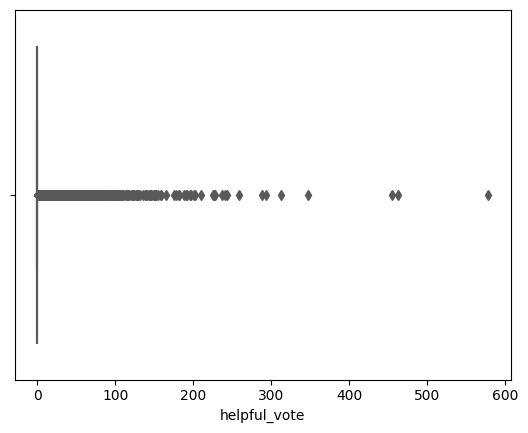

In [22]:
sns.boxplot(x="helpful_vote", data=df, palette="Set2")

In [23]:
#print the quantile (0.5, 0.7, 0.9, 0.95 and 0.99) of balance variable
df.helpful_vote.quantile([0.5,0.7, 0.9, 0.95, 0.99, 0.995, 0.9995])

0.5000     0.0
0.7000     0.0
0.9000     1.0
0.9500     3.0
0.9900     9.0
0.9950    15.0
0.9995    61.0
Name: helpful_vote, dtype: float64

In [24]:
df["helpful_vote_Rel"] = df.helpful_vote.apply(lambda x: 1 if x >= 1 else 0)
df.helpful_vote_Rel.value_counts(normalize=True)

helpful_vote_Rel
0    0.789422
1    0.210578
Name: proportion, dtype: float64

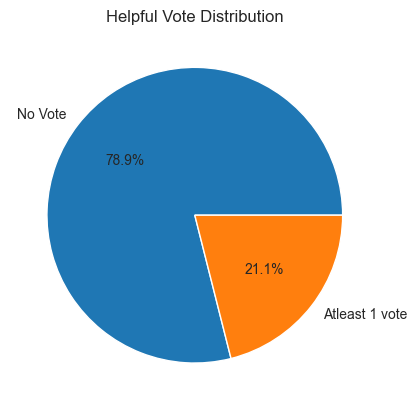

In [25]:
sns.set_style("whitegrid")
plt.pie(df["helpful_vote_Rel"].value_counts(normalize=True), labels=['No Vote', 'Atleast 1 vote'], autopct="%1.1f%%")
plt.title("Helpful Vote Distribution")
plt.show()

As we see that almost 80% of the purchase data either doesn't have any helpful votes.

In [26]:
#create the buckets of <5, 5-10, 10-20, 20-50, 50-100, 100-200, 200-500, 500+ column.
df['helpful_vote_range'] = pd.cut(df.helpful_vote, [0, 5, 10, 20, 50, 100, 200, 500, 9999],
            labels=["<5", "5-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"])
df.helpful_vote_range.value_counts(normalize=True)

helpful_vote_range
<5         0.903322
5-10       0.055750
10-20      0.026278
20-50      0.011485
50-100     0.002364
100-200    0.000629
200-500    0.000162
500+       0.000010
Name: proportion, dtype: float64

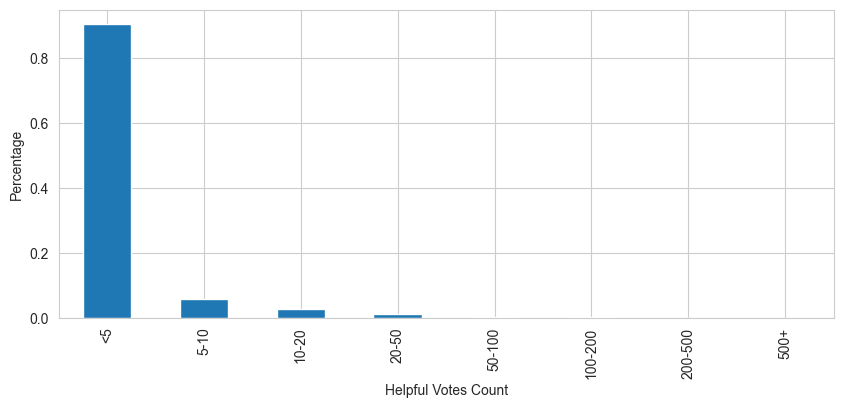

In [27]:
plt.figure(figsize=[10, 4])
df.helpful_vote_range.value_counts(normalize=True).plot.bar()
plt.xlabel("Helpful Votes Count")
plt.ylabel("Percentage")
plt.show()

 Among the rest 20%, approximately 90% of then have less than or equal to 5 votes. Hence this feature doesn't hold any significance for building the recommendation model.

##### Analyze Timestamp feature

Convert the timestamp to days count from the last purchase date

In [28]:
print("Most Frequent Purchase date -", df['timestamp'].max())
print("Most Historic Purchase date -", df['timestamp'].min())

Most Frequent Purchase date - 2023-03-29 03:03:15.139000
Most Historic Purchase date - 2002-10-05 07:53:31


In [29]:
df['time_seconds'] = df.timestamp.apply(lambda x: int(x.timestamp()))

In [30]:
#Calculate the past no of days from the current date to determine the purchase frequencey in days
# User's last purchase
df['timestamp_freqLast'] = (df['timestamp'].max() - df['timestamp']).dt.total_seconds()

In [31]:
df['timestamp_freqDays'] = np.ceil(df['timestamp_freqLast']/(60*60*24))
df['timestamp_freqDays'] = df['timestamp_freqDays'].apply(lambda x : 1 if x == 0.0 else x)
df['timestamp_freqDays'] = np.round(df['timestamp_freqDays'])

Users purchasing count in weeks/months interval. 1 month, 2-3 months, 3-6 months, 6-9 months, 6-12 months, 12-15 months, 15-18 months, 18-21 months, 21-24 months, 2-2.5years, more than 2.5 years with an interval of 6 months

In [32]:
#create the buckets of <1 month, 1-3 months, 3-6 months, 6-9 months, 9-12 months, 12-15 months,
# 15-18 months, 18-21 months, 21-24 months, 2-2.5years, more than 2.5 years with an interval of 6 months
# from timestamp column.
df['purchase_freq'] = pd.cut(df.timestamp_freqDays, [0, 30, 90, 180, 272, 365, 450, 540, 630, 720,
                                    900, 1080, 1260, 1440, 1620, 1800, 1980, 2160, 3340, 3520, 3700,
                                    3880, 4060, 4240, 4420, 4600, 4780, 4960, 9999],
        labels=["<1 month", "1-3 months", "3-6 months", "6-9 months", "6-12 months",
            "12-15 months", "15-18 months", "18-21 months", "21-24 months", "2-2.5 years", "2.5-3 years",
            "3-3.5 years", "3.5-4 years", "4-4.5 years", "5-5.5 years", "5.5-6 years", "6-6.5 years",
            "6.5-7 years", "7-7.5 years", "7.5-8 years", "8-8.5 years", "8.5-9 years", "9-9.5 years",
            "9.5-10 years", "10-10.5 years", "10.5-11 years", "11-11.5 years", "11.5+ years"])
df.purchase_freq.value_counts()

purchase_freq
6.5-7 years      116949
3.5-4 years       42125
3-3.5 years       39561
4-4.5 years       38444
6-6.5 years       37100
5.5-6 years       36772
5-5.5 years       36605
2-2.5 years       33212
2.5-3 years       27037
21-24 months      16764
18-21 months      14067
15-18 months      11765
12-15 months       9847
6-12 months        8768
6-9 months         8513
3-6 months         7985
1-3 months         3959
7-7.5 years        2583
7.5-8 years        1650
<1 month           1334
8-8.5 years        1249
11.5+ years         492
8.5-9 years         379
9-9.5 years         360
10-10.5 years       216
9.5-10 years        209
11-11.5 years       147
10.5-11 years       132
Name: count, dtype: int64

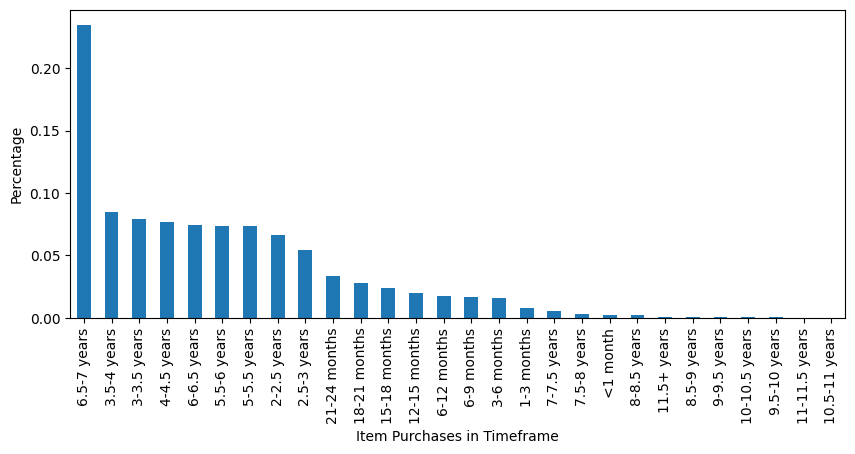

In [33]:
plt.rcdefaults()
plt.figure(figsize=[10, 4])
df.purchase_freq.value_counts(normalize=True).plot.bar()
plt.xlabel("Item Purchases in Timeframe")
plt.ylabel("Percentage")
plt.show()

User Item purchase distribution across month

In [34]:
df['purchase_month'] = df.timestamp.apply(lambda x : x.month)

In [35]:
months_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
              7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

In [36]:
df.purchase_month = df.purchase_month.map(months_map)

In [37]:
df.purchase_month.value_counts(normalize=True)

purchase_month
Jan    0.102460
Dec    0.097420
Jul    0.089400
Aug    0.086495
Mar    0.082055
Oct    0.081174
Jun    0.080948
Feb    0.079075
May    0.077704
Nov    0.076040
Sep    0.074129
Apr    0.073100
Name: proportion, dtype: float64

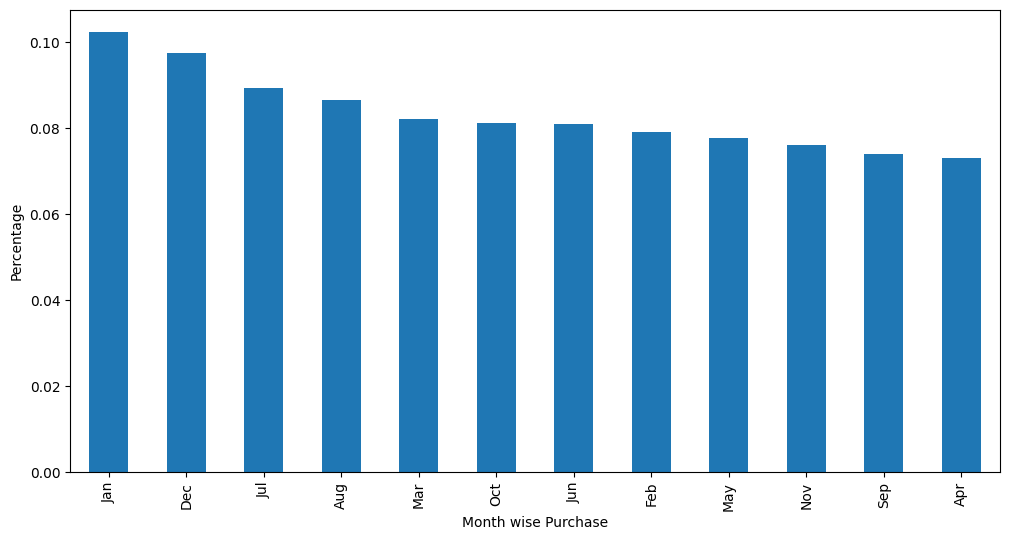

In [38]:
plt.figure(figsize=[12, 6])
df.purchase_month.value_counts(normalize=True).plot.bar()
plt.xlabel("Month wise Purchase")
plt.ylabel("Percentage")
plt.show()

The purchases across the months have been consistent with an average weightage, 7.5% of total purchasings in every month. This is almost equally distributed. Among these, January, December and July are being the top 3 months with maximum purchasings and this shows some seasonality, considering winter and summer peak months.

In [39]:
df['purchase_year'] = df.timestamp.apply(lambda x : x.year)

In [40]:
df.purchase_year.value_counts(normalize=True)

purchase_year
2019    0.169723
2018    0.152494
2017    0.150452
2020    0.124763
2021    0.122327
2016    0.115314
2022    0.071572
2015    0.048677
2014    0.021181
2023    0.010010
2013    0.008075
2012    0.002497
2011    0.001052
2010    0.000692
2009    0.000458
2008    0.000345
2007    0.000269
2006    0.000054
2005    0.000022
2004    0.000018
2003    0.000004
2002    0.000002
Name: proportion, dtype: float64

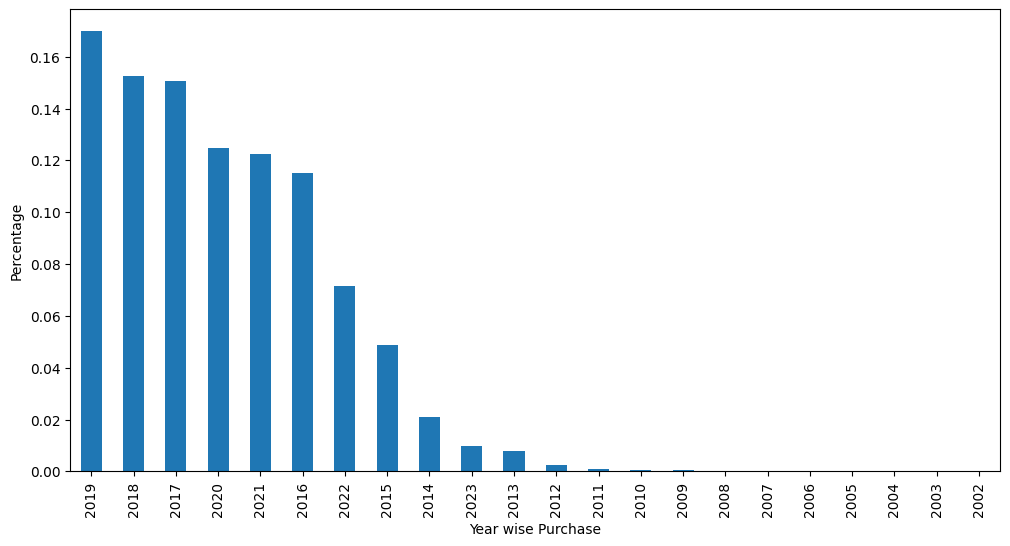

In [41]:
plt.figure(figsize=[12, 6])
df.purchase_year.value_counts(normalize=True).plot.bar()
plt.xlabel("Year wise Purchase")
plt.ylabel("Percentage")
plt.show()

#### Data Filtraion

In [42]:
print("Start Data Filtration")
print_user_items_count(df)

Start Data Filtration
Dataset shape: (498224, 17) Users count: 342412 Items count: 289229


Filter the data with historical transactions of past 10 years

In [43]:
df.timestamp = pd.to_datetime(df.timestamp)
# Historical transactions of past 10 years only
df['timestamp_seconds'] = (df['timestamp'] - dt.datetime(2021,1,1)).dt.total_seconds()
df = df[~(df.timestamp_seconds < 0)]

In [44]:
print("Most Frequent Purchase date - ", df['timestamp'].max())
print("Most Historic Purchase date - ", df['timestamp'].min())

Most Frequent Purchase date -  2023-03-29 03:03:15.139000
Most Historic Purchase date -  2021-01-01 00:03:53.570000


In [45]:
print("After filtering with historical transactions of last 10 years")
print_user_items_count(df)

After filtering with historical transactions of last 10 years
Dataset shape: (101592, 18) Users count: 83967 Items count: 72515


Filter the data with verified purchase as False

In [46]:
df[df.verified_purchase == False].shape

(15169, 18)

In [47]:
df = df[~(df.verified_purchase == False)]

In [48]:
print("After filtering with verified_purchase = True")
print_user_items_count(df)

After filtering with verified_purchase = True
Dataset shape: (86423, 18) Users count: 76484 Items count: 62036


Filter the data with rating less than 3 as these will not be potential items for next purchasings

In [49]:
MIN_RATING = 3
df = df[~(df.rating < MIN_RATING)]

In [50]:
print("After filtering with min rating of 3")
print_user_items_count(df)

After filtering with min rating of 3
Dataset shape: (68467, 18) Users count: 61434 Items count: 49239


Drop extra columns

In [51]:
df.drop(columns=['timestamp_seconds', 'timestamp_freqLast', 'timestamp_freqDays', 'purchase_month',
                 'purchase_freq', 'helpful_vote_range', 'helpful_vote_Rel'], axis=1, inplace=True)

#### Data Preparation

Arrange the user items data in a sequential manner based on timestamp in chronological order of purchase. For a user the recent item purchase will be in the last of the item sequence.

In [52]:
print("Start Data Preparation for Recommendation Model")
df = df.sort_values('timestamp')
df.head()

Start Data Preparation for Recommendation Model


,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,time_seconds,purchase_year
402155,5,Easiest mitts to get on a toddler EVER.,"These are currently really big on my toddler, ...",B01BZPQKRU,B09FFLK4K8,AHC2IHCKPO4FIHIHXJ6DM2P7FXYQ,2021-01-01 00:03:53.570,2,1,1609459433,2021
52368,5,Peppa socks,My daughter loves peppa pig and she just loves...,B08JVJ3RKP,B08JVJ3RKP,AFMFE56YG75IYMRQAXTJR74E2XZA,2021-01-01 00:45:07.871,0,1,1609461907,2021
396466,4,NOT BAD BUT IT HAPPENS,It looks great except for that little broken p...,B08BTQCJLX,B08BTQCJLX,AHQ74ZZEAGLNQMRJYZWFHCVOXP6A,2021-01-01 01:05:39.267,1,1,1609463139,2021
362363,5,Bru,This sweater arrived quickly and is perfect! I...,B00BBWAFAG,B084LJ5ZJ5,AF7NTT44JFMOZKHGQZSF6HPTIOIA,2021-01-01 01:11:42.052,0,1,1609463502,2021
443491,5,Good quality,It fit nice . It is also a good quality dress .,B08JM3ZQ5R,B08JM3ZQ5R,AGJVCT272HHA3RYRJW2RIGQNO5XA,2021-01-01 01:26:25.996,0,1,1609464385,2021


In [53]:
df.pivot_table(index = "user_id", values = ["parent_asin"], aggfunc='count')

,parent_asin
user_id,
AE22236AFRRSMQIKGG7TPTB75QEA,1
AE2235Q53V246ISFXCSESYHAVNUA,1
AE224MHK2TEDK6MRZZKR7HFGHAJA,1
AE226DXXSDWPBFTQB3M4VMOVZR2A,1
AE226IHCMYPYN4AIZKNRVH7ETC4A,2
...,...
AHZZVJXUGI72HIC3PZBPJRZ2JRUQ,1
AHZZXO5WVCFS76PUJ73YY6OFUMKQ,1
AHZZYZ2ZNIDOJKRXALZBIX7VVKYA,1


##### Filter the users which have atleast 3 historical items data

In [54]:
df_user_items_count = pd.DataFrame(df.groupby("user_id")["parent_asin"].count())
df_user_items_count.columns = ["items_count"]
print("Max Items rated by an user", df_user_items_count.items_count.max())
print("Min Items rated by an user", df_user_items_count.items_count.min())
df_user_items_count[df_user_items_count.items_count == df_user_items_count.items_count.max()]

Max Items rated by an user 33
Min Items rated by an user 1


,items_count
user_id,
AGUTZC4GHLTGYHA3KBEDRF6MHB6A,33


In [55]:
MIN_NO_OF_ITEMS = 3
user_items_count = df_user_items_count[df_user_items_count.items_count >= MIN_NO_OF_ITEMS]
user_items_count = user_items_count.reset_index()
user_items_count

,user_id,items_count
0,AE2FAN53WPSSI2FX5FZARVARNW7A,5
1,AE2HFFCMK35SAAUPF3OQSBD5P44Q,3
2,AE2HXAF3Y2IA327U36QQKJHCZVMQ,4
3,AE2ONOMTM7IRFWRULYZA2WIRYFDA,6
4,AE2VIMKO7UFYDUU4LH46JLON3DMQ,3
...,...,...
975,AHYYWLYIEDAYOEL6NI3R5KIDEEUA,3
976,AHZ2B2EIN7GWE2624T46O3MYR5EA,3
977,AHZGWIR46O3Q3DFJQWKJCVOGQI4A,4
978,AHZWXGMYYXL4UYKD5O3GAPLPOT5Q,3


In [56]:
user_items_count.items_count.sum()

3547

In [57]:
users = np.array(user_items_count.user_id)
user_items_count = None
df_user_items = df[df.user_id.isin(users)].sort_values(["user_id", "time_seconds"], ascending=[True, False])[["user_id", "rating", "parent_asin", "time_seconds"]]
df_user_items.head()

,user_id,rating,parent_asin,time_seconds
181428,AE2FAN53WPSSI2FX5FZARVARNW7A,5,B08WCS16V5,1621937843
181429,AE2FAN53WPSSI2FX5FZARVARNW7A,4,B089YMMZGC,1614760740
181430,AE2FAN53WPSSI2FX5FZARVARNW7A,5,B085MDJ59W,1614760704
181431,AE2FAN53WPSSI2FX5FZARVARNW7A,5,B017RZE222,1614759417
181432,AE2FAN53WPSSI2FX5FZARVARNW7A,5,B081LKZRR9,1609867522


In [58]:
print("Filtering the users which have atleast 5 historical items data")
print_user_items_count(df_user_items)

Filtering the users which have atleast 5 historical items data
Dataset shape: (3547, 4) Users count: 980 Items count: 3422


In [59]:
# Importing application modules
from tokenization.simple_tokenizer import *

In [60]:
MODE_USER_ITEM='user_item'
MODE_ITEM_USER='item_user'

In [61]:
def createTokenizedFile(data, filename, mode, ncf=False):
    print("Creating tokeinzed file for mode:", mode, "Filename:", filename)
    user_tokenizer = SimpleTokenizer()
    item_tokenizer = SimpleTokenizer()
    with open(filename, "wb") as file:
        if mode == 'user_item':
            for rec in data.itertuples():
                user_token = user_tokenizer.tokenize(rec.user_id)
                item_token = item_tokenizer.tokenize(rec.parent_asin)
                if ncf:
                    user_item_token = str(user_token) + "::" + str(item_token) + "::" + str(rec.rating) + "::" + str(rec.time_seconds)
                else:
                    user_item_token = str(user_token) + " " + str(item_token)
                if (user_token < 5):
                    print(user_item_token)
                line = user_item_token + os.linesep
                line = bytes(line, "utf-8")
                file.write(line)
        elif mode == 'item_user':
            for rec in data.itertuples():
                item_token = item_tokenizer.tokenize(rec.parent_asin)
                user_token = user_tokenizer.tokenize(rec.user_id)
                if ncf:
                    item_user_token = str(item_token) + "::" + str(user_token) + "::" + str(rec.rating) + "::" + str(rec.time_seconds)
                else:
                    item_user_token = str(item_token) + " " + str(user_token)
                if (item_token < 5):
                    print(item_user_token)
                line = item_user_token + os.linesep
                line = bytes(line, "utf-8")
                file.write(line)
        else:
            print("Invalid mode, it should be either 'user_item' or 'item_user'")
        file.close()

In [62]:
createTokenizedFile(data=df_user_items, filename='user_item.txt', mode=MODE_USER_ITEM)

Creating tokeinzed file for mode: user_item Filename: user_item.txt
1 1
1 2
1 3
1 4
1 5
2 6
2 7
2 8
3 9
3 10
3 11
3 12
4 13
4 14
4 15
4 16
4 17
4 18


##### Filter Items which have been rated by atleast 5 users

In [63]:
df_items_user_count = pd.DataFrame(df.groupby("parent_asin")["user_id"].count())
df_items_user_count.columns = ["user_count"]
print("Max Users rating an item", df_items_user_count.user_count.max())
print("Min Users rating an item", df_items_user_count.user_count.min())
df_items_user_count[df_items_user_count.user_count == df_items_user_count.user_count.max()]

Max Users rating an item 623
Min Users rating an item 1


,user_count
parent_asin,
B09KHSM7BB,623


In [64]:
df_items_user_count.user_count.describe()

count    49239.000000
mean         1.390503
std          4.394572
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        623.000000
Name: user_count, dtype: float64

In [65]:
df_items_user_count.user_count.quantile([0.5,0.7, 0.9, 0.95, 0.99, 0.995, 0.9995, 0.9999, 1])

0.5000      1.0000
0.7000      1.0000
0.9000      2.0000
0.9500      2.0000
0.9900      7.0000
0.9950     13.0000
0.9995     58.3810
0.9999    156.3434
1.0000    623.0000
Name: user_count, dtype: float64

<AxesSubplot: xlabel='user_count'>

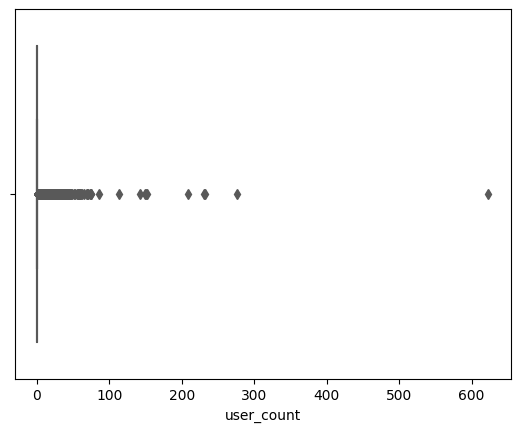

In [66]:
sns.boxplot(x="user_count", data=df_items_user_count, palette="Set2")

In [67]:
len(df_items_user_count[df_items_user_count.user_count >= 100])

10

In [68]:
df_temp4 = df_items_user_count[(df_items_user_count.user_count >= 5) & (df_items_user_count.user_count <= 100)]
df_temp4.shape

(923, 1)

In [69]:
df_temp = df_items_user_count[df_items_user_count.user_count >= 100]
df_temp.reset_index(inplace=True)
#df_temp

<AxesSubplot: xlabel='user_count'>

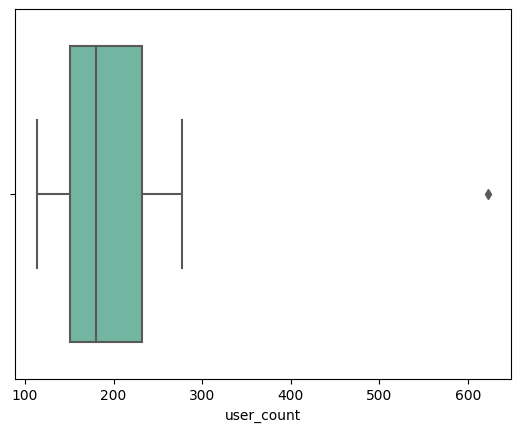

In [70]:
sns.boxplot(x="user_count", data=df_temp, palette="Set2")

In [71]:
df_temp1 = df[df.parent_asin.isin(df_temp.parent_asin)].sort_values(['user_id', 'time_seconds'], ascending=[True, False])[["user_id", "rating", "parent_asin", "time_seconds"]]
df_temp1.reset_index(inplace=True, drop=True)
df_temp1

,user_id,rating,parent_asin,time_seconds
0,AE22MNQ5AUUQDKLYUQJLBQVB4HYQ,5,B09KHSM7BB,1667701444
1,AE22XFHINBB7BMI4QM6WW77JTFBA,5,B0B16Q1854,1617576025
2,AE242ZZNGN76NJGBHE5ATA73NBTQ,5,B09H6MXJ71,1630783787
3,AE27DWV4V56WFNBRVMX27EEQWSQA,5,B0B16Q1854,1618060642
4,AE2A226FHJWOHSF2ISASG3O52LRQ,3,B09KHSM7BB,1653681345
...,...,...,...,...
2277,AHZRDCXJKRECA3CDZEIEXZ44C2OA,5,B09TXZHKLG,1629313507
2278,AHZT47GFOBYXAEUYMPZJFFVEE7DA,5,B09KHSM7BB,1668723292
2279,AHZU4DCNUOOHVOZBLVDQFBJC6ISQ,5,B09TXZHKLG,1625965453
2280,AHZUDWHX5OG36RCHUQJUMR5YKT2A,5,B09TXZHKLG,1641529807


In [72]:
df_temp2 = pd.DataFrame(df_temp1.groupby('parent_asin')['time_seconds'].rank(method='first', ascending=False))
df_temp2.columns = ['rank']
df_temp2

,rank
0,142.0
1,111.0
2,85.0
3,107.0
4,173.0
...,...
2277,127.0
2278,130.0
2279,139.0
2280,104.0


In [73]:
df_temp2['rank'].describe()

count    2282.000000
mean      157.724803
std       144.308700
min         1.000000
25%        58.000000
50%       115.000000
75%       201.000000
max       623.000000
Name: rank, dtype: float64

In [74]:
df_temp3 = pd.merge(df_temp1, df_temp2, left_index=True, right_index=True, how='left')
df_temp3

,user_id,rating,parent_asin,time_seconds,rank
0,AE22MNQ5AUUQDKLYUQJLBQVB4HYQ,5,B09KHSM7BB,1667701444,142.0
1,AE22XFHINBB7BMI4QM6WW77JTFBA,5,B0B16Q1854,1617576025,111.0
2,AE242ZZNGN76NJGBHE5ATA73NBTQ,5,B09H6MXJ71,1630783787,85.0
3,AE27DWV4V56WFNBRVMX27EEQWSQA,5,B0B16Q1854,1618060642,107.0
4,AE2A226FHJWOHSF2ISASG3O52LRQ,3,B09KHSM7BB,1653681345,173.0
...,...,...,...,...,...
2277,AHZRDCXJKRECA3CDZEIEXZ44C2OA,5,B09TXZHKLG,1629313507,127.0
2278,AHZT47GFOBYXAEUYMPZJFFVEE7DA,5,B09KHSM7BB,1668723292,130.0
2279,AHZU4DCNUOOHVOZBLVDQFBJC6ISQ,5,B09TXZHKLG,1625965453,139.0
2280,AHZUDWHX5OG36RCHUQJUMR5YKT2A,5,B09TXZHKLG,1641529807,104.0


In [75]:
df_temp3[df_temp3.parent_asin == 'B09KHSM7BB']['rank'].describe()

count    623.000000
mean     312.000000
std      179.988889
min        1.000000
25%      156.500000
50%      312.000000
75%      467.500000
max      623.000000
Name: rank, dtype: float64

In [76]:
df_2 = df[['user_id', "rating", "parent_asin", "time_seconds"]]

In [77]:
df_temp5 = pd.DataFrame(df_2.groupby('parent_asin')['time_seconds'].rank(method='first', ascending=False))
df_temp5.columns = ['rank']
df_temp5

,rank
402155,1.0
52368,1.0
396466,1.0
362363,22.0
443491,1.0
...,...
497857,1.0
485084,1.0
487209,1.0
492292,1.0


In [78]:
df_temp5['rank'].describe()

count    68467.000000
mean         8.139454
std         38.854141
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        623.000000
Name: rank, dtype: float64

In [79]:
df_item_users = pd.merge(df_2, df_temp5, left_index=True, right_index=True, how='left')
df_item_users

,user_id,rating,parent_asin,time_seconds,rank
402155,AHC2IHCKPO4FIHIHXJ6DM2P7FXYQ,5,B09FFLK4K8,1609459433,1.0
52368,AFMFE56YG75IYMRQAXTJR74E2XZA,5,B08JVJ3RKP,1609461907,1.0
396466,AHQ74ZZEAGLNQMRJYZWFHCVOXP6A,4,B08BTQCJLX,1609463139,1.0
362363,AF7NTT44JFMOZKHGQZSF6HPTIOIA,5,B084LJ5ZJ5,1609463502,22.0
443491,AGJVCT272HHA3RYRJW2RIGQNO5XA,5,B08JM3ZQ5R,1609464385,1.0
...,...,...,...,...,...
497857,AFGVGVCE4SSBAD66FJBOP6X5ZMQQ,5,B09PGRT6YZ,1680013579,1.0
485084,AG7URIUQCKBS7TJDMEWLK7AF273A,3,B08XYJ9MXB,1680019004,1.0
487209,AGB2XU355LZ5CHXQHJVI5LIIASCQ,4,B09LCLHGQ2,1680028486,1.0
492292,AESDQ236C3ENV7U7A3TQQAXGCZTQ,5,B07Y727W2F,1680041428,1.0


In [80]:
df_item_users[df_item_users.parent_asin == 'B0041IC244']

,user_id,rating,parent_asin,time_seconds,rank
432201,AFO5TDVOQNVMGPZTFBFG2RUXZ4MQ,3,B0041IC244,1635353621,1.0


In [81]:
df_item_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68467 entries, 402155 to 482094
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       68467 non-null  object 
 1   rating        68467 non-null  int64  
 2   parent_asin   68467 non-null  object 
 3   time_seconds  68467 non-null  int64  
 4   rank          68467 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.1+ MB


In [82]:
MIN_NO_OF_USERS = 5
items_user_count = df_items_user_count[(df_items_user_count.user_count >= MIN_NO_OF_USERS)]
items_user_count = items_user_count.reset_index()
items_user_count

,parent_asin,user_count
0,B003P8QPIA,10
1,B003WJZDQW,5
2,B003YD92JU,19
3,B004FUV0EQ,12
4,B004H2RD4I,6
...,...,...
928,B0C7GFPT42,7
929,B0C7PYGJJQ,6
930,B0C8YZKZ7G,7
931,B0CBMHPJRQ,9


In [83]:
items_user_count.user_count.sum()

13316

In [84]:
items = np.array(items_user_count.parent_asin)
df_item_users = df_item_users[df_item_users.parent_asin.isin(items) & (df_item_users['rank'] <= 100)].sort_values(["parent_asin", "time_seconds"])[["user_id", "rating", "parent_asin", "time_seconds", "rank"]]
df_item_users.head()

,user_id,rating,parent_asin,time_seconds,rank
369815,AHQYNLW7ARVF5LFY5USF2RFNIM6Q,4,B003P8QPIA,1622318431,10.0
26974,AFKQY6KICWHZATHUQ63KSWLFUZAA,5,B003P8QPIA,1623987224,9.0
363340,AE5CIPFDGNBDELBBK7VOJZ43UGEA,4,B003P8QPIA,1624508891,8.0
92527,AH7IT66UQ2STXJGOVUOX2SUPVBWQ,5,B003P8QPIA,1627318757,7.0
453601,AGUTZUT3ZSMAOAKEU2F6B2AKMJBA,4,B003P8QPIA,1649267330,6.0


In [85]:
print_user_items_count(df_item_users)

Dataset shape: (12034, 5) Users count: 11796 Items count: 933


In [86]:
MIN_NO_OF_USERS = 5
MAX_NO_OF_USERS = 100
items_user_count = df_items_user_count[(df_items_user_count.user_count >= MIN_NO_OF_USERS) & (df_items_user_count.user_count <= MAX_NO_OF_USERS)]
items_user_count = items_user_count.reset_index()
items_user_count

,parent_asin,user_count
0,B003P8QPIA,10
1,B003WJZDQW,5
2,B003YD92JU,19
3,B004FUV0EQ,12
4,B004H2RD4I,6
...,...,...
918,B0C7GFPT42,7
919,B0C7PYGJJQ,6
920,B0C8YZKZ7G,7
921,B0CBMHPJRQ,9


In [87]:
items_user_count.user_count.sum()

11034

In [88]:
items = np.array(items_user_count.parent_asin)
items_user_count = None
df_item_users = df[df.parent_asin.isin(items)].sort_values(["parent_asin", "time_seconds"])[["user_id", "rating", "parent_asin", "time_seconds"]]
df_item_users.head()

,user_id,rating,parent_asin,time_seconds
369815,AHQYNLW7ARVF5LFY5USF2RFNIM6Q,4,B003P8QPIA,1622318431
26974,AFKQY6KICWHZATHUQ63KSWLFUZAA,5,B003P8QPIA,1623987224
363340,AE5CIPFDGNBDELBBK7VOJZ43UGEA,4,B003P8QPIA,1624508891
92527,AH7IT66UQ2STXJGOVUOX2SUPVBWQ,5,B003P8QPIA,1627318757
453601,AGUTZUT3ZSMAOAKEU2F6B2AKMJBA,4,B003P8QPIA,1649267330


In [89]:
print("Filtering Items which have been rated by atleast 5 users")
print_user_items_count(df_item_users)

Filtering Items which have been rated by atleast 5 users
Dataset shape: (11034, 4) Users count: 10831 Items count: 923


In [90]:
createTokenizedFile(data=df_item_users, filename='item_user.txt', mode=MODE_ITEM_USER)

Creating tokeinzed file for mode: item_user Filename: item_user.txt
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 11
2 12
2 13
2 14
2 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46


In [91]:
user_items = df[(df.user_id.isin(users)) & (df.parent_asin.isin(items))].sort_values(["user_id", "time_seconds"])[["user_id", "rating", "parent_asin", "time_seconds"]]
user_items.head()

,user_id,rating,parent_asin,time_seconds
269835,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,B09L8B5CJL,1646986451
10196,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,4,B08THC47S1,1659295282
291036,AE5IQA2MU4A55EYTPK4MY5R62R2A,4,B08R73KWRM,1614277770
103553,AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,5,B0886B2NJ3,1662767238
328769,AE6BPIGX3OPIREID6EN6XMZUA5PQ,3,B07YCGPP4N,1623614127


In [92]:
print("Filtering common Users-Items and Items-Users")
print_user_items_count(user_items)

Filtering common Users-Items and Items-Users
Dataset shape: (291, 4) Users count: 223 Items count: 213


In [93]:
user_items.shape

(291, 4)

In [94]:
final_users = np.array(user_items.user_id)
final_user_items = df[df.user_id.isin(final_users)].sort_values(["user_id", "time_seconds"])[["user_id", "rating", "text", "parent_asin", "time_seconds"]]
final_user_items.head()

,user_id,rating,text,parent_asin,time_seconds
269836,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,Very well made and comfortable to wear,B0881NRVNM,1625726088
269835,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,Keeps your hands warm,B09L8B5CJL,1646986451
269834,AE2VIMKO7UFYDUU4LH46JLON3DMQ,4,They will be great to cover my silver platters...,B0BKZNWSFN,1679208965
10199,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,5,The price was my only issue. Otherwise I LOVE ...,B08K8CV3GT,1642948885
10197,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,4,Wish they had more variety on colors. Also tir...,B08K8DB14M,1659295230


In [95]:
print("Filtered Users and Items for the Sentiment task model")
print_user_items_count(final_user_items)

Filtered Users and Items for the Sentiment task model
Dataset shape: (847, 5) Users count: 223 Items count: 765


In [96]:
final_user_items.shape

(847, 5)

In [97]:
createTokenizedFile(data=final_user_items, filename='fashion.txt', mode=MODE_USER_ITEM)

Creating tokeinzed file for mode: user_item Filename: fashion.txt
1 1
1 2
1 3
2 4
2 5
2 6
3 7
3 8
3 9
4 10
4 11
4 12


In [98]:
check

NameError: name 'check' is not defined

##### Define sentiment label column
This will be used to capture user sentiment. 1=Positive, 0=Negative

In [ ]:
final_user_items.text[:5]

Standardise the text for processing

In [ ]:
def text_standardization(input):
    punctuations = r"""!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~"""
    lowercase = tf.strings.lower(input)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    text = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(punctuations), '')
    text = str(text)[12:-26][:500] # consider text max 500 words
    return text.strip()

In [ ]:
final_user_items['text'] = final_user_items.text.apply(lambda x : text_standardization(x))

In [ ]:
final_user_items.reset_index(drop=True, inplace=True)

In [ ]:
final_user_items.head()

In [ ]:
check

##### Sentiment Labeling based on review text

In [ ]:
print("Sentiment Label task modeling", len(list(final_user_items['text'][:5])), "\n", final_user_items['text'][:5])

In [ ]:
from sentiment_classification import *

In [ ]:
sentimentClassifier = SentimentClassification()

In [ ]:
BATCH_SIZE = 6
sentiment_labels = sentimentClassifier.get_sentiment_labels(final_user_items, "text", BATCH_SIZE)

In [ ]:
sentiment_labels[:10]

In [ ]:
sentiment_labels = pd.DataFrame(sentiment_labels)
sentiment_labels.columns = ["sentiment_label"]
sentiment_labels.head()

In [ ]:
df = pd.concat([final_user_items, sentiment_labels], axis = 1)
df.head()

In [ ]:
df.sentiment_label.value_counts(normalize=True)

Filter the Items with negative sentiments, i.e sentiment_label as 0

In [ ]:
df = df[~(df.sentiment_label == 0)]
df.reset_index(drop=True, inplace=True)

In [ ]:
print("Filtering positive sentiment labelled data")
print_user_items_count(df)

### Model Building: Recommendation Model

We will build User-User and item-item collaborative filtering recommendation System and use it for recommending products. Later we will combine the selected recommendation filter and user the sentiment to filter the products with positive reviews<br>

- User-User: Find similar users first and then recommend products to users which would have been rated high by the similar group of users<br>
- Item-Item: Find similar items based on ratings and use that to recommend the top rated products to users

Build the dataset needed for Recommendation Engine<br>
Earlier we had kept the dataset df intact for classification and recommendation

In [113]:
# Verify df has no missing data
df = final_user_items.copy()
df.reset_index(drop=True, inplace=True)
MissingData(df)
df_recommendation = df[["user_id", "rating", "parent_asin"]]
print(df_recommendation.shape)
df_recommendation.head(5)

(847, 3)


,user_id,rating,parent_asin
0,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,B0881NRVNM
1,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,B09L8B5CJL
2,AE2VIMKO7UFYDUU4LH46JLON3DMQ,4,B0BKZNWSFN
3,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,5,B08K8CV3GT
4,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,4,B08K8DB14M


Split the recommendation dataset into train and test

In [114]:
print("Train test data split ration 80:20")

Train test data split ration 80:20


In [115]:
train, test = train_test_split(df_recommendation, test_size=0.20, random_state=42)

In [116]:
df_recommendation

,user_id,rating,parent_asin
0,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,B0881NRVNM
1,AE2VIMKO7UFYDUU4LH46JLON3DMQ,5,B09L8B5CJL
2,AE2VIMKO7UFYDUU4LH46JLON3DMQ,4,B0BKZNWSFN
3,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,5,B08K8CV3GT
4,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,4,B08K8DB14M
...,...,...,...
842,AHYIGWZI55BCZNQU3P5TYANO2K5Q,5,B07BTLBSMD
843,AHYIGWZI55BCZNQU3P5TYANO2K5Q,5,B09DYG2ZCH
844,AHZ2B2EIN7GWE2624T46O3MYR5EA,5,B08DJ9NL6Y
845,AHZ2B2EIN7GWE2624T46O3MYR5EA,5,B07ZHXWQZV


Name columns for the recommendation dataset

In [117]:
product_column = "parent_asin" #id
user_column = "user_id" #reviews_username
value_column = "rating"

Create Pivot dataset in matrix format with columns as product IDs and rows as user names so we get a view of whch user has rated which product and what value

In [147]:
df_user_recommendation_pivot = pd.pivot_table(
    train, index=user_column, columns=product_column, values=value_column
).fillna(0)
df_user_recommendation_pivot.head(10)

parent_asin,B009R09Z8W,B00C6GC9VO,B00CE4B8LU,B00CLKYSIC,B00DEZ4O9Q,B00H4DL9II,B00HR53DUK,B00HXD0R2S,B00LPRHHY4,B00O972MCO,...,B0BX4BVC5J,B0BYCZ2W78,B0BYH37QQK,B0BZRRTDZH,B0C1H4ZJ11,B0C1NKM232,B0C3R8G4N8,B0C5D72QHD,B0C7CGGN6L,B0CBMHPJRQ
user_id,,,,,,,,,,,,,,,,,,,,,
AE2VIMKO7UFYDUU4LH46JLON3DMQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE5IQA2MU4A55EYTPK4MY5R62R2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6BPIGX3OPIREID6EN6XMZUA5PQ,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6LT7RKZ2T4NJ7NJAHLMHSKVXHA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE73ZWLPQHFFF6NQQAJXSZBRYVKA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE7KIPZOIJBM34G7XULNLK675JXA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE7Q25GSRLHTETTDP46MZ5N2S3LA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
df_user_recommendation_pivot.shape

(222, 623)

##### Dummy train dataset

We will create dummy train and dummy test dataset to mark the products already rated by the user so that they dont come up during prediction or evaluation


In [149]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
# The products not rated by a user is marked as 1 for prediction. this matrix form now has 1 and 0 with 1 as products not rated by the user
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x >= 1 else 1)
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(
    dummy_train, index=user_column, columns=product_column, values=value_column
).fillna(1)
dummy_train.head(10)

parent_asin,B009R09Z8W,B00C6GC9VO,B00CE4B8LU,B00CLKYSIC,B00DEZ4O9Q,B00H4DL9II,B00HR53DUK,B00HXD0R2S,B00LPRHHY4,B00O972MCO,...,B0BX4BVC5J,B0BYCZ2W78,B0BYH37QQK,B0BZRRTDZH,B0C1H4ZJ11,B0C1NKM232,B0C3R8G4N8,B0C5D72QHD,B0C7CGGN6L,B0CBMHPJRQ
user_id,,,,,,,,,,,,,,,,,,,,,
AE2VIMKO7UFYDUU4LH46JLON3DMQ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE5IQA2MU4A55EYTPK4MY5R62R2A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE6BPIGX3OPIREID6EN6XMZUA5PQ,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE6LT7RKZ2T4NJ7NJAHLMHSKVXHA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE73ZWLPQHFFF6NQQAJXSZBRYVKA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE7KIPZOIJBM34G7XULNLK675JXA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE7Q25GSRLHTETTDP46MZ5N2S3LA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Adjusted cosine similarity measure will be used now to capture similarities between different users.

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user, we subtract average ratings for each user from each user's rating for different products.

In [150]:
df_user_recommendation_pivot.index.nunique()
# using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_user_recommendation_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(222, 222)


##### User-Based Recommendation Model

User - User similarity predicition with the use of above correlation matrix. no correlation value of 0<br>
Making negative correlations to 0

In [151]:
user_correlation[user_correlation < 0] = 0

In [152]:
# taking a dot product of User correlation matrix and the pivot matrix
user_predicted_ratings = np.dot(user_correlation, df_user_recommendation_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Multiply the predicted ratings with dummy matrix as we dont want the products which are already rated

In [153]:
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

parent_asin,B009R09Z8W,B00C6GC9VO,B00CE4B8LU,B00CLKYSIC,B00DEZ4O9Q,B00H4DL9II,B00HR53DUK,B00HXD0R2S,B00LPRHHY4,B00O972MCO,...,B0BX4BVC5J,B0BYCZ2W78,B0BYH37QQK,B0BZRRTDZH,B0C1H4ZJ11,B0C1NKM232,B0C3R8G4N8,B0C5D72QHD,B0C7CGGN6L,B0CBMHPJRQ
user_id,,,,,,,,,,,,,,,,,,,,,
AE2VIMKO7UFYDUU4LH46JLON3DMQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE5IQA2MU4A55EYTPK4MY5R62R2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6BPIGX3OPIREID6EN6XMZUA5PQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Top 20 recommendations for a sample user

In [154]:
user_input = df_recommendation["user_id"][5]
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

Show the top 20 recommended products - product id, name and similarity_score

In [155]:
final_recommendations = pd.DataFrame(
    {"product_id": recommendations.index, "similarity_score": recommendations}
)
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="parent_asin")[
    ["parent_asin", "similarity_score"]
].drop_duplicates()

,parent_asin,similarity_score
0,B009R09Z8W,0.0
1,B093H35R4V,0.0
2,B092QX7S11,0.0
3,B092V32LST,0.0
4,B092V3Z4K3,0.0
5,B092V7YV18,0.0
6,B0932VX738,0.0
7,B0936HG79P,0.0
8,B093DPD63S,0.0
9,B093P4LY24,0.0


Since prediction is now done, we will move to evaluation for User-User Collborative<br>
Find out the common users of test and train dataset.

In [156]:
common = test[test.user_id.isin(train.user_id)]
common.shape
# Convert into the user-product matrix.
common_user_based_matrix = pd.pivot_table(
    common, index=user_column, columns=product_column, values=value_column
)
common_user_based_matrix.head()
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()
user_correlation_df[user_column] = df_user_recommendation_pivot.index
user_correlation_df.set_index(user_column, inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
user_id,,,,,,,,,,,,,,,,,,,,,
AE2VIMKO7UFYDUU4LH46JLON3DMQ,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AE5IQA2MU4A55EYTPK4MY5R62R2A,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AE6BPIGX3OPIREID6EN6XMZUA5PQ,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.224544,0.0,0.0,0.0


Get the list of users from the common dataset from train and test

In [157]:
list_name = common.user_id.tolist()

Create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index

In [158]:
user_correlation_df.columns = df_user_recommendation_pivot.index.tolist()
user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape
# create user correlation matrix 2 with a transpose of matrix 1 with the list of common users
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
# create user correlation matrix 2 with a transpose of matrix 2
user_correlation_df_3 = user_correlation_df_2.T
# Mark the correlattion value with 0 for the negative correlations
user_correlation_df_3[user_correlation_df_3 < 0] = 0
# get the recommendations by doing a dot product of correlations and ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Create a dummy test dataset with the common users and create a pivot matrix of the same

In [159]:
dummy_recommendation_test = common.copy()
dummy_recommendation_test[value_column] = dummy_recommendation_test[value_column].apply(
    lambda x: 1 if x >= 1 else 0
)
dummy_recommendation_test = pd.pivot_table(
    dummy_recommendation_test, index=user_column, columns=product_column, values=value_column
).fillna(0)
dummy_recommendation_test.shape
# print both the matrix which has users and the evaluation test recommendations
common_user_based_matrix.head()
dummy_recommendation_test.head()
# get the final evaluation for the products not rated by the users in the test set
common_user_predicted_ratings = np.multiply(
    common_user_predicted_ratings, dummy_recommendation_test
)
print(common_user_predicted_ratings.head())

parent_asin                   B00DEZ4O9Q  B00J7S0SQW  B00O972MCO  B01DV8BVWS  \
user_id                                                                        
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ         0.0         0.0         0.0         0.0   
AE5IQA2MU4A55EYTPK4MY5R62R2A         0.0         0.0         0.0         0.0   
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA         0.0         0.0         0.0         0.0   
AE7KIPZOIJBM34G7XULNLK675JXA         0.0         0.0         0.0         0.0   
AEAJ4VVMLVSZ26FS4TOEJVJDHVHA         0.0         0.0         0.0         0.0   

parent_asin                   B01E58TWQA  B01M72IYBS  B01N55PHLH  B074FGK626  \
user_id                                                                        
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ         0.0         0.0         0.0         0.0   
AE5IQA2MU4A55EYTPK4MY5R62R2A         0.0         0.0         0.0         0.0   
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA         0.0         0.0         0.0         0.0   
AE7KIPZOIJBM34G7XULNLK675JXA         0.

Calculate RMSE from the user-user evaluation

In [ ]:
X = common_user_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))
common_ = pd.pivot_table(common, index=user_column, columns=product_column, values=value_column)
print("Common predictions", common_.head())
#Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
print("total_non_nan", total_non_nan)
print("y_predicted", y)
user_rmse = (sum(sum((common_ - y) ** 2)) / total_non_nan) ** 0.5
# print the final RMSE
print("User-based RMSE", user_rmse)

Common predictions parent_asin                   B00DEZ4O9Q  B00J7S0SQW  B00O972MCO  B01DV8BVWS  \
user_id                                                                        
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ         NaN         NaN         NaN         NaN   
AE5IQA2MU4A55EYTPK4MY5R62R2A         NaN         NaN         NaN         NaN   
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA         NaN         NaN         NaN         NaN   
AE7KIPZOIJBM34G7XULNLK675JXA         NaN         NaN         NaN         NaN   
AEAJ4VVMLVSZ26FS4TOEJVJDHVHA         NaN         NaN         NaN         NaN   

parent_asin                   B01E58TWQA  B01M72IYBS  B01N55PHLH  B074FGK626  \
user_id                                                                        
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ         NaN         NaN         NaN         NaN   
AE5IQA2MU4A55EYTPK4MY5R62R2A         NaN         NaN         NaN         NaN   
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA         NaN         NaN         NaN         NaN   
AE7KIPZOIJBM34G7XULN

##### Item-Based Recommendation Model

In [134]:
# Item-Item Based Recommendation
df_item_recommendation_pivot = pd.pivot_table(
    train, index=product_column, columns=user_column, values=value_column
)
df_item_recommendation_pivot.head()

user_id,AE2VIMKO7UFYDUU4LH46JLON3DMQ,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,AE5IQA2MU4A55EYTPK4MY5R62R2A,AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,AE6BPIGX3OPIREID6EN6XMZUA5PQ,AE6LT7RKZ2T4NJ7NJAHLMHSKVXHA,AE73ZWLPQHFFF6NQQAJXSZBRYVKA,AE7KIPZOIJBM34G7XULNLK675JXA,AE7Q25GSRLHTETTDP46MZ5N2S3LA,AEAJ4VVMLVSZ26FS4TOEJVJDHVHA,...,AHVI7N6YSQH7IMMXLMO2FCEMLMNA,AHVPCLHSCEUSA4MF2QU7JHL2NTUA,AHW5ZTDAGECVI5OQGHKRC5VAGG4A,AHWGPCCFFOHQLMGEHHFUQJPMG77A,AHX5VKX55PILNNCSUZFRHLH7FLIA,AHX7GH4OTFLIAAPK4F2CPPQJOCUQ,AHXZWTZ2JMSDZ6QNQBD35GZS4VIA,AHY75QEHC3DLIZOOYW2KNDAQ4EIQ,AHYIGWZI55BCZNQU3P5TYANO2K5Q,AHZ2B2EIN7GWE2624T46O3MYR5EA
parent_asin,,,,,,,,,,,,,,,,,,,,,
B009R09Z8W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00C6GC9VO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00CE4B8LU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00CLKYSIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00DEZ4O9Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
mean = np.nanmean(df_item_recommendation_pivot, axis=1)
df_subtracted = (df_item_recommendation_pivot.T - mean).T
df_subtracted.head()

user_id,AE2VIMKO7UFYDUU4LH46JLON3DMQ,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,AE5IQA2MU4A55EYTPK4MY5R62R2A,AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,AE6BPIGX3OPIREID6EN6XMZUA5PQ,AE6LT7RKZ2T4NJ7NJAHLMHSKVXHA,AE73ZWLPQHFFF6NQQAJXSZBRYVKA,AE7KIPZOIJBM34G7XULNLK675JXA,AE7Q25GSRLHTETTDP46MZ5N2S3LA,AEAJ4VVMLVSZ26FS4TOEJVJDHVHA,...,AHVI7N6YSQH7IMMXLMO2FCEMLMNA,AHVPCLHSCEUSA4MF2QU7JHL2NTUA,AHW5ZTDAGECVI5OQGHKRC5VAGG4A,AHWGPCCFFOHQLMGEHHFUQJPMG77A,AHX5VKX55PILNNCSUZFRHLH7FLIA,AHX7GH4OTFLIAAPK4F2CPPQJOCUQ,AHXZWTZ2JMSDZ6QNQBD35GZS4VIA,AHY75QEHC3DLIZOOYW2KNDAQ4EIQ,AHYIGWZI55BCZNQU3P5TYANO2K5Q,AHZ2B2EIN7GWE2624T46O3MYR5EA
parent_asin,,,,,,,,,,,,,,,,,,,,,
B009R09Z8W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00C6GC9VO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00CE4B8LU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00CLKYSIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00DEZ4O9Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create Item similarity matrix using cosine similarity

In [136]:
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric="cosine")
item_correlation[np.isnan(item_correlation)] = 0

In [137]:
item_correlation[item_correlation < 0] = 0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Prediction Item-Item recommendation

In [138]:
item_predicted_ratings = np.dot((df_item_recommendation_pivot.fillna(0).T), item_correlation)
item_predicted_ratings
# filtering for the products not rated by the users
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
item_final_rating.head()

parent_asin,B009R09Z8W,B00C6GC9VO,B00CE4B8LU,B00CLKYSIC,B00DEZ4O9Q,B00H4DL9II,B00HR53DUK,B00HXD0R2S,B00LPRHHY4,B00O972MCO,...,B0BX4BVC5J,B0BYCZ2W78,B0BYH37QQK,B0BZRRTDZH,B0C1H4ZJ11,B0C1NKM232,B0C3R8G4N8,B0C5D72QHD,B0C7CGGN6L,B0CBMHPJRQ
user_id,,,,,,,,,,,,,,,,,,,,,
AE2VIMKO7UFYDUU4LH46JLON3DMQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE5IQA2MU4A55EYTPK4MY5R62R2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE6BPIGX3OPIREID6EN6XMZUA5PQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Top 20 recommendations for a sample user

In [139]:
user_input = df_recommendation["user_id"][5]
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

In [140]:
# Show the top 20 recommended products - product id, name and similarity_score
item_final_recommendations = pd.DataFrame(
    {"product_id": item_recommendations.index, "similarity_score": item_recommendations}
)
item_final_recommendations.reset_index(drop=True)
pd.merge(item_final_recommendations, train, on="parent_asin")[
    ["parent_asin", "similarity_score"]
].drop_duplicates()

,parent_asin,similarity_score
0,B009R09Z8W,0.0
1,B093H35R4V,0.0
2,B092QX7S11,0.0
3,B092V32LST,0.0
4,B092V3Z4K3,0.0
5,B092V7YV18,0.0
6,B0932VX738,0.0
7,B0936HG79P,0.0
8,B093DPD63S,0.0
9,B093P4LY24,0.0


Now the prediction is done, let's do the evaluation for item - item recommendation

In [141]:
common = test[test.parent_asin.isin(train.parent_asin)]
print(common.shape)
common.head(5)

(24, 3)


,user_id,rating,parent_asin
655,AH5FXVT7D47KI5FRNYUTMDJRVCVA,5,B07DY3H2XX
694,AHECDVJJZ7PDO434WFMRKOARM6BA,3,B07DY3H2XX
542,AGSU4RCPOFE6IOCQ6G4MSVQ6Z2SA,5,B08DDJP75V
198,AFATCMRRSNTQEQ5RWROIDOQWH2GA,5,B00DEZ4O9Q
593,AGV5HKOIFCE2IUEODPJOB3A5QY3A,5,B09F98ZDRW


In [142]:
common_item_based_matrix = common.pivot_table(
    index=product_column, columns=user_column, values=value_column
)

In [143]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,613,614,615,616,617,618,619,620,621,622
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column, inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,613,614,615,616,617,618,619,620,621,622
parent_asin,,,,,,,,,,,,,,,,,,,,,
B009R09Z8W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00C6GC9VO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00CE4B8LU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00CLKYSIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00DEZ4O9Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
list_name = common.parent_asin.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
# create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
# create correlations 3 with transpose of 2
item_correlation_df_3 = item_correlation_df_2.T
df_subtracted

user_id,AE2VIMKO7UFYDUU4LH46JLON3DMQ,AE3RXOZQ6OBTBWRG6C3N5ZYC4NWQ,AE5IQA2MU4A55EYTPK4MY5R62R2A,AE6BOFNBB4PIQIPQFVZPVYR2ZQHA,AE6BPIGX3OPIREID6EN6XMZUA5PQ,AE6LT7RKZ2T4NJ7NJAHLMHSKVXHA,AE73ZWLPQHFFF6NQQAJXSZBRYVKA,AE7KIPZOIJBM34G7XULNLK675JXA,AE7Q25GSRLHTETTDP46MZ5N2S3LA,AEAJ4VVMLVSZ26FS4TOEJVJDHVHA,...,AHVI7N6YSQH7IMMXLMO2FCEMLMNA,AHVPCLHSCEUSA4MF2QU7JHL2NTUA,AHW5ZTDAGECVI5OQGHKRC5VAGG4A,AHWGPCCFFOHQLMGEHHFUQJPMG77A,AHX5VKX55PILNNCSUZFRHLH7FLIA,AHX7GH4OTFLIAAPK4F2CPPQJOCUQ,AHXZWTZ2JMSDZ6QNQBD35GZS4VIA,AHY75QEHC3DLIZOOYW2KNDAQ4EIQ,AHYIGWZI55BCZNQU3P5TYANO2K5Q,AHZ2B2EIN7GWE2624T46O3MYR5EA
parent_asin,,,,,,,,,,,,,,,,,,,,,
B009R09Z8W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00C6GC9VO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00CE4B8LU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00CLKYSIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B00DEZ4O9Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0C1NKM232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B0C3R8G4N8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B0C5D72QHD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mark the correlation value with 0 for the negative correlations

In [ ]:
item_correlation_df_3[item_correlation_df_3 < 0] = 0
# get the recommendations by doing a dot product of correlations and ratings
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
print(common_item_predicted_ratings)

Create a dummy test dataset with the common users and create a pivot matrix of the same

In [ ]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = pd.pivot_table(
    dummy_test, index=product_column, columns=user_column, values=value_column
).fillna(0)
# get the final evaluation for the products not rated by the users in the test set
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
common_ = pd.pivot_table(common, index=product_column, columns=user_column, values=value_column)

Calculate RMSE from the item-item evaluation

In [ ]:
X = common_item_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
item_rmse = (sum(sum((common_ - y) ** 2)) / total_non_nan) ** 0.5
# print the final rmse value
print(item_rmse)

##### Recommendation Model selection

In [ ]:
recommendation_results = pd.DataFrame({"Recommendation Method": ['User-Based', 'Item-Based'],
              "Evaluation Metric(RMSE)" : [user_rmse, item_rmse]})
print(recommendation_results)

RMSE for User-User based recommendation method is almost equal to Item-Item, hence we will use both the User based and Item based collaborative filtering for building the Hybrid Recommendation model.

Saving the model

In [ ]:
# Pickle saved files directory
ML_MODELS_DIRECTORY = "model_files/"

In [ ]:
def save_model(model, filename):
    file_path = ML_MODELS_DIRECTORY + filename
    pickle.dump(model, open(file_path, "wb"))
    print("Recommendation model saved,", file_path)

In [ ]:
# save the final user-user based collaborative recommendation model
RECOMMENDATION_MODEL = "user-based-recommendation-model.pkl"
save_model(user_final_rating, RECOMMENDATION_MODEL)

In [ ]:
# save the final item-item based collaborative recommendation model
RECOMMENDATION_MODEL = "item-based-recommendation-model.pkl"
save_model(item_final_rating, RECOMMENDATION_MODEL)

In [ ]:
print("Hybrid Recommendation Model with Sentiment Analysis completed")